In [14]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400


def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image


def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("/content/drive/MyDrive/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("/content/drive/MyDrive/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("/content/drive/MyDrive/low/*"))


train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


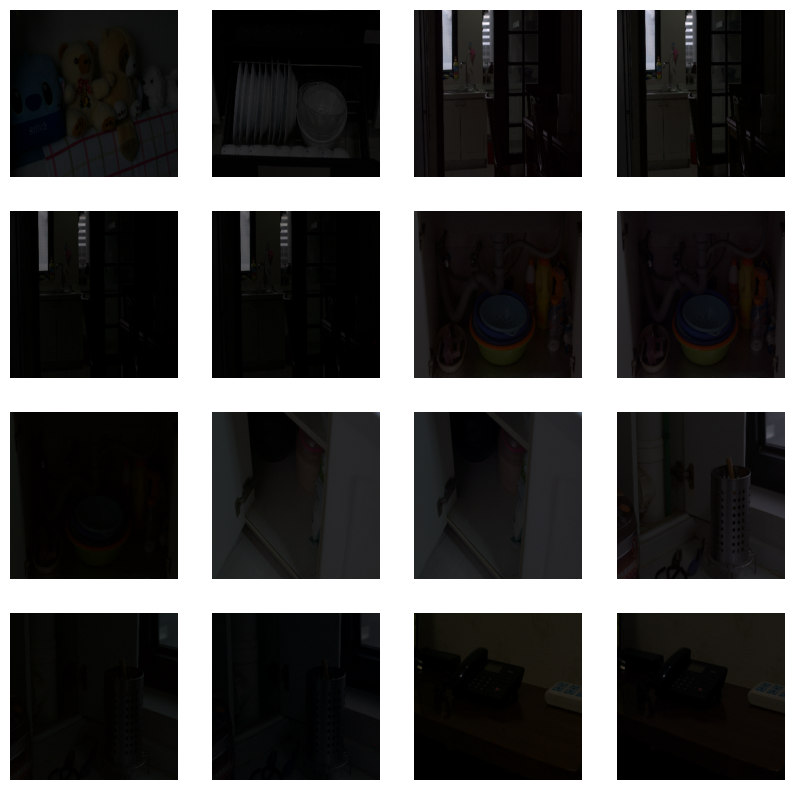

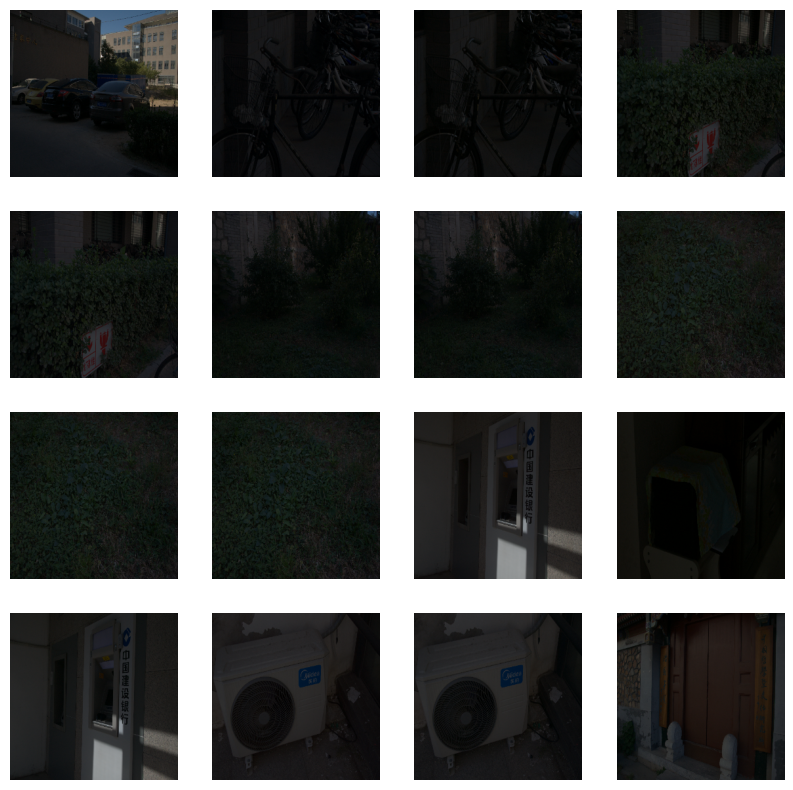

In [17]:
import matplotlib.pyplot as plt

def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i])
        plt.axis("off")

# Get a batch of images from the train dataset
for image_batch in train_dataset.take(1):
    show_batch(image_batch.numpy())
    break

# Get a batch of images from the validation dataset
for image_batch in val_dataset.take(1):
    show_batch(image_batch.numpy())
    break


In [18]:
## Reference :- https://keras.io/examples/vision/zero_dce/
def build_dce_net():
    """
    Builds the Deep Curve Estimation (DCE) network model.

    Returns:
        A Keras model representing the DCE-Net.
    """
    # Input layer for the model
    input_layer = keras.Input(shape=[None, None, 3])

    # First four convolutional layers with ReLU activation
    conv_layer1 = layers.Conv2D(
        filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_layer)

    conv_layer2 = layers.Conv2D(
        filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv_layer1)

    conv_layer3 = layers.Conv2D(
        filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv_layer2)

    conv_layer4 = layers.Conv2D(
        filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv_layer3)

    # Concatenation of the third and fourth convolutional layers
    concat1 = layers.Concatenate(axis=-1)([conv_layer4, conv_layer3])

    # Fifth convolutional layer after concatenation
    conv_layer5 = layers.Conv2D(
        filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"
    )(concat1)

    # Concatenation of the fifth layer with the second convolutional layer
    concat2 = layers.Concatenate(axis=-1)([conv_layer5, conv_layer2])

    # Sixth convolutional layer after the second concatenation
    conv_layer6 = layers.Conv2D(
        filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"
    )(concat2)

    # Final concatenation with the first convolutional layer
    concat3 = layers.Concatenate(axis=-1)([conv_layer6, conv_layer1])

    # Output layer with tanh activation to generate the enhancement maps
    output_layer = layers.Conv2D(
        filters=24, kernel_size=(3, 3), strides=(1, 1), activation="tanh", padding="same"
    )(concat3)

    # Building the Keras model
    dce_net_model = keras.Model(inputs=input_layer, outputs=output_layer)

    return dce_net_model


In [19]:
def color_constancy_loss(image):

    # Calculate the mean value for each color channel (red, green, blue)
    mean_channels = tf.reduce_mean(image, axis=(1, 2), keepdims=True)
    mean_red = mean_channels[:, :, :, 0]
    mean_green = mean_channels[:, :, :, 1]
    mean_blue = mean_channels[:, :, :, 2]

    # Compute the squared differences between the mean values of the channels
    diff_red_green = tf.square(mean_red - mean_green)
    diff_red_blue = tf.square(mean_red - mean_blue)
    diff_green_blue = tf.square(mean_green - mean_blue)

    # Calculate the color constancy loss
    color_loss = tf.sqrt(tf.square(diff_red_green) + tf.square(diff_red_blue) + tf.square(diff_green_blue))

    return color_loss



In [20]:
def exposure_loss(image, desired_mean=0.6):


    # Calculate the mean intensity across the color channels for each pixel
    mean_intensity = tf.reduce_mean(image, axis=3, keepdims=True)

    # Perform average pooling to get the local average intensity values
    local_mean = tf.nn.avg_pool2d(mean_intensity, ksize=16, strides=16, padding="VALID")

    # Compute the exposure loss as the mean squared difference from the desired mean value
    loss = tf.reduce_mean(tf.square(local_mean - desired_mean))

    return loss


In [21]:
def illumination_smoothness_loss(enhancement_map):
    batch_dim = tf.shape(enhancement_map)[0]
    height_dim = tf.shape(enhancement_map)[1]
    width_dim = tf.shape(enhancement_map)[2]

    # Compute the count of height and width elements for normalization
    height_elements = (tf.shape(enhancement_map)[2] - 1) * tf.shape(enhancement_map)[3]
    width_elements = tf.shape(enhancement_map)[2] * (tf.shape(enhancement_map)[3] - 1)

    # Calculate the total variation across height and width dimensions
    height_variation = tf.reduce_sum(tf.square(enhancement_map[:, 1:, :, :] - enhancement_map[:, :height_dim - 1, :, :]))
    width_variation = tf.reduce_sum(tf.square(enhancement_map[:, :, 1:, :] - enhancement_map[:, :, :width_dim - 1, :]))

    # Convert batch size and element counts to float for normalization
    batch_dim_float = tf.cast(batch_dim, dtype=tf.float32)
    height_elements_float = tf.cast(height_elements, dtype=tf.float32)
    width_elements_float = tf.cast(width_elements, dtype=tf.float32)

    # Compute the normalized smoothness loss
    smoothness_loss = 2 * (height_variation / height_elements_float + width_variation / width_elements_float) / batch_dim_float

    return smoothness_loss

In [22]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down

In [23]:
class CustomDCE(keras.Model):
    def __init__(self, **kwargs):
        super(CustomDCE, self).__init__(**kwargs)
        self.enhance_net = build_dce_net()

    def compile(self, lr, **kwargs):
        super(CustomDCE, self).compile(**kwargs)
        self.opt = keras.optimizers.Adam(learning_rate=lr)
        self.consistency_loss = SpatialConsistencyLoss(reduction="none")

    def enhance_image(self, input_image, enhancement_factors):
        """Apply enhancement factors progressively to the input image."""
        stage_1 = enhancement_factors[:, :, :, :3]
        stage_2 = enhancement_factors[:, :, :, 3:6]
        stage_3 = enhancement_factors[:, :, :, 6:9]
        stage_4 = enhancement_factors[:, :, :, 9:12]
        stage_5 = enhancement_factors[:, :, :, 12:15]
        stage_6 = enhancement_factors[:, :, :, 15:18]
        stage_7 = enhancement_factors[:, :, :, 18:21]
        stage_8 = enhancement_factors[:, :, :, 21:24]

        enhanced_img = input_image + stage_1 * (tf.square(input_image) - input_image)
        enhanced_img = enhanced_img + stage_2 * (tf.square(enhanced_img) - enhanced_img)
        enhanced_img = enhanced_img + stage_3 * (tf.square(enhanced_img) - enhanced_img)
        enhanced_img = enhanced_img + stage_4 * (tf.square(enhanced_img) - enhanced_img)
        enhanced_img = enhanced_img + stage_5 * (tf.square(enhanced_img) - enhanced_img)
        enhanced_img = enhanced_img + stage_6 * (tf.square(enhanced_img) - enhanced_img)
        enhanced_img = enhanced_img + stage_7 * (tf.square(enhanced_img) - enhanced_img)
        final_image = enhanced_img + stage_8 * (tf.square(enhanced_img) - enhanced_img)

        return final_image

    def call(self, inputs):
        enhancement_params = self.enhance_net(inputs)
        return self.enhance_image(inputs, enhancement_params)

    def compute_losses(self, original_image, enhancement_params):
        enhanced_image = self.enhance_image(original_image, enhancement_params)
        loss_illumination_smoothness = 200 * illumination_smoothness_loss(enhancement_params)
        loss_spatial_consistency = tf.reduce_mean(self.consistency_loss(enhanced_image, original_image))
        loss_color_consistency = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_proper_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))

        total_loss_value = (
            loss_illumination_smoothness
            + loss_spatial_consistency
            + loss_color_consistency
            + loss_proper_exposure
        )

        return {
            "total_loss": total_loss_value,
            "illumination_loss": loss_illumination_smoothness,
            "spatial_loss": loss_spatial_consistency,
            "color_loss": loss_color_consistency,
            "exposure_loss": loss_proper_exposure,
        }

    def train_step(self, data_batch):
        with tf.GradientTape() as tape:
            enhancement_outputs = self.enhance_net(data_batch)
            loss_dict = self.compute_losses(data_batch, enhancement_outputs)

        grads = tape.gradient(loss_dict["total_loss"], self.enhance_net.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.enhance_net.trainable_variables))

        return loss_dict

    def test_step(self, data_batch):
        enhancement_outputs = self.enhance_net(data_batch)
        return self.compute_losses(data_batch, enhancement_outputs)

    def save_model_weights(self, path, overwrite=True, save_format=None, options=None):
        """Save weights for the enhancement network."""
        self.enhance_net.save_weights(
            path, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_model_weights(self, path, by_name=False, skip_mismatch=False, options=None):
        """Load weights into the enhancement network."""
        self.enhance_net.load_weights(
            filepath=path, by_name=by_name, skip_mismatch=skip_mismatch, options=options
        )

In [25]:
zero_dce_model = CustomDCE()
zero_dce_model.compile(lr=1e-2,metrics=['accuracy'])
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=20)




Epoch 1/20
25/25 [==============================] - 11s 304ms/step - total_loss: 2.3537 - illumination_loss: 0.1793 - spatial_loss: 0.0310 - color_loss: 0.0128 - exposure_loss: 2.1305 - val_total_loss: 1.6543 - val_illumination_loss: 0.0459 - val_spatial_loss: 0.1070 - val_color_loss: 0.0122 - val_exposure_loss: 1.4892
Epoch 2/20
25/25 [==============================] - 7s 269ms/step - total_loss: 1.1747 - illumination_loss: 0.0437 - spatial_loss: 0.2897 - color_loss: 0.0845 - exposure_loss: 0.7569 - val_total_loss: 1.3596 - val_illumination_loss: 0.0073 - val_spatial_loss: 0.2359 - val_color_loss: 0.0286 - val_exposure_loss: 1.0878
Epoch 3/20
25/25 [==============================] - 8s 324ms/step - total_loss: 1.1036 - illumination_loss: 0.0097 - spatial_loss: 0.2860 - color_loss: 0.0815 - exposure_loss: 0.7265 - val_total_loss: 1.3507 - val_illumination_loss: 0.0029 - val_spatial_loss: 0.2457 - val_color_loss: 0.0372 - val_exposure_loss: 1.0649
Epoch 4/20
25/25 [=====================

In [26]:


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

In [27]:
enhanced_images=[]
for val_image_file in test_low_light_images:
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)
    enhanced_images.append(enhanced_image)
    original_image_np = np.array(original_image)
    enhanced_image_np = np.array(enhanced_image)




In [28]:
zero_dce_model.save_weights('/content/drive/MyDrive/dce_model_new.h5')

In [35]:
zero_dce_model2=CustomDCE()
# Create a dummy input with the correct shape
dummy_input = tf.zeros((1, 256, 256, 3))  # Assuming your input images are 256x256 RGB
# Call the model to build it and create variables
_ = zero_dce_model2(dummy_input)
zero_dce_model2.load_weights('/content/drive/MyDrive/dce_model_new.h5')

In [36]:
image_path = '/content/drive/MyDrive/WhatsApp Image 2024-06-14 at 13.22.50.png'


image = Image.open(image_path)
image_array = np.array(image)
image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0
image_tensor = tf.expand_dims(image_tensor, axis=0)
output_tensor = zero_dce_model2(image_tensor)
output_image_array = tf.cast(output_tensor[0, :, :, :] * 255, dtype=tf.uint8).numpy()

output_image = Image.fromarray(output_image_array)



In [37]:
test_high_light_images = sorted(glob("/content/drive/MyDrive/high/*"))

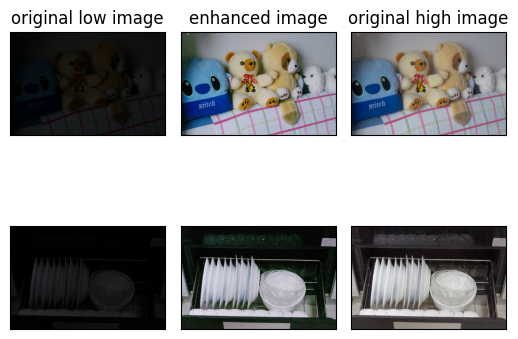

In [38]:
## visualising the sample output on a random image
fig,axs=plt.subplots(2,3)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
original_high_1=Image.open(test_high_light_images[0])
original_high_2=Image.open(test_high_light_images[1])
original_high_1=np.array(original_high_1,dtype=np.float32)
original_high_2=np.array(original_high_2,dtype=np.float32)
original_high_1=original_high_1/255.0
original_high_2=original_high_2/255.0


val_image=test_low_light_images[0]
original_image=Image.open(val_image)
original_image=np.array(original_image,dtype=np.float32)
original_image=original_image/255.0
axs[0,2].imshow(original_high_1)
axs[0,2].set_title('original high image')
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])
axs[1,2].imshow(original_high_2)

axs[1,2].set_xticks([])
axs[1,2].set_yticks([])
### Checking the output of first validation images
axs[0,0].imshow(original_image)
axs[0,0].set_title('original low image')
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
image_tensor=tf.convert_to_tensor(original_image,dtype=tf.float32)
image_tensor=tf.expand_dims(image_tensor,axis=0)
output_tensor=zero_dce_model2(image_tensor)
output_image_array=tf.cast(output_tensor[0,:,:,:]*255,dtype=tf.uint8).numpy()
axs[0,1].set_title('enhanced image')
axs[0,1].imshow(output_image_array)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
### visualising the output of second validation image
val_image=test_low_light_images[1]
original_image=Image.open(val_image)
original_image=np.array(original_image,dtype=np.float32)
original_image=original_image/255.0

axs[1,0].imshow(original_image)

axs[1,0].set_xticks([])
axs[1,0].set_yticks([])
image_tensor=tf.convert_to_tensor(original_image,dtype=tf.float32)
image_tensor=tf.expand_dims(image_tensor,axis=0)
output_tensor=zero_dce_model2(image_tensor)
output_image_array=tf.cast(output_tensor[0,:,:,:]*255,dtype=tf.uint8).numpy()
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
axs[1,1].imshow(output_image_array)


In [39]:
## calculation of psnr score
import numpy as np

def calculate_psnr(original_image, enhanced_image):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Parameters:
    - original_image (np.ndarray): The original reference image.
    - enhanced_image (np.ndarray): The enhanced image to compare.

    Returns:
    - psnr (float): The PSNR value in decibels.
    """
    # Ensure the input images are in the correct format and dimensions
    original_image = np.array(original_image, dtype=np.float32)
    enhanced_image = np.array(enhanced_image, dtype=np.float32)

    if original_image.shape != enhanced_image.shape:
        raise ValueError("Input images must have the same dimensions and channels")

    # Compute the Mean Squared Error (MSE)
    mse = np.mean((original_image - enhanced_image) ** 2)

    if mse == 0:
        return float('inf')  # If the MSE is zero, the PSNR is infinite

    # Set the maximum pixel value
    max_pixel_value = 255.0

    # Compute the PSNR
    psnr = 10 * np.log10(max_pixel_value / np.sqrt(mse))

    return psnr
peak=0
for i in range(len(test_low_light_images)):
    original_image=test_low_light_images[i]
    original_image=Image.open(original_image)
    original_image=np.array(original_image,dtype=np.float32)
    original_image=original_image/255.0
    enhanced_image=enhanced_images[i]
    enhanced_image=np.array(enhanced_image,dtype=np.float32)
    enhanced_image=enhanced_image/255.0
    peak=peak+calculate_psnr(original_image,enhanced_image)
print(peak/len(test_low_light_images))

27.60372623313091
